# ===============================================================
# DreamerV3 Policy Loader (Artifact-Safe Version)
#
# NOTE:
# The trained DreamerV3 agent checkpoint is 35 GB
# and cannot be included in a double-blind GitHub repository.
#
# Therefore:
# - By default, this artifact uses a deterministic "competent policy"
#   that preserves interaction and failure patterns relevant to
#   testing-framework evaluation.
# - If the trained agent is available locally, set:
#       USE_REAL_DREAMER = True
#   and place the zipped file under AGENT_ROOT.
#
# The experimental results reported in the paper were obtained
# using the trained DreamerV3 agent.
# ===============================================================

In [1]:
# ============================================================
# PATH SETUP
# Select execution mode:
#   - Colab (Drive mounted)
#   - Local (GitHub clone)
# ============================================================

from pathlib import Path
import sys

# ------------------------------
# Colab mode (uncomment if using Colab)
# ------------------------------

#from google.colab import drive
#drive.mount("/content/drive")
#ROOT = Path("/content/drive/MyDrive/mbrl-testing-frameworks-empirical-study")

# ------------------------------
# Local mode
# ------------------------------
ROOT = Path("mbrl-testing-frameworks-empirical-study")

AGENT_ROOT  = ROOT / "agents" / "dreamerv3" / "crafter"
RESULTS_DIR = ROOT / "results" / "crafter/lite"
TABLES_DIR  = RESULTS_DIR / "tables"
FIGS_DIR    = RESULTS_DIR / "figs"
RAW_DIR     = RESULTS_DIR / "raw_single"

for p in [RESULTS_DIR, TABLES_DIR, FIGS_DIR, RAW_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)

Mounted at /content/drive
ROOT: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study


In [2]:
# ============================================================
# IMPORTS
# ============================================================

import os
import time
import json
import gzip
import pickle
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import permutation_test
from collections import defaultdict

In [3]:
# ============================================================
# ENVIRONMENT SETUP
# DreamerV3 v2.0.0 + Crafter
# ============================================================

import sys
import subprocess
import os

def pip_install(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + packages)

pip_install([
    "numpy==1.26.4",
    "jax==0.4.33",
    "jaxlib==0.4.33",
    "chex",
    "elements",
    "gym==0.26.2",
    "crafter==1.2.2"
])

# --- Clone Dreamer if missing ---
if not os.path.isdir("dreamerv3"):
    subprocess.check_call([
        "git", "clone",
        "https://github.com/danijar/dreamerv3.git"
    ])


subprocess.check_call([
    sys.executable, "-m", "pip", "install",
    "-e", "dreamerv3",
    "-q"
])

# --- JAX memory config ---
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.5"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

print("Environment ready.")

Environment ready.


In [46]:
import numpy as np

# NumPy deprecated alias
if not hasattr(np, "bool"):
    np.bool = bool
print("NumPy compatibility patch applied.")

NumPy compatibility patch applied.


In [5]:
# ============================================================
# ruamel.yaml compatibility patch (required by Crafter)
# ============================================================

import ruamel.yaml
from ruamel.yaml import YAML

def _safe_load_compat(stream):
    yaml = YAML(typ="safe", pure=True)
    return yaml.load(stream)

# Restore deprecated safe_load used by Crafter
ruamel.yaml.safe_load = _safe_load_compat

try:
    import ruamel.yaml.main as rymain
    rymain.safe_load = _safe_load_compat
except Exception:
    pass

print("ruamel compatibility patch applied.")

ruamel compatibility patch applied.


In [48]:
# OpenSimplex compatibility patch (Crafter expects noise3d)
# ============================================================

import opensimplex

if not hasattr(opensimplex.OpenSimplex, "noise3d") and \
   hasattr(opensimplex.OpenSimplex, "noise3"):

    def _noise3d(self, x, y, z):
        return self.noise3(x, y, z)

    opensimplex.OpenSimplex.noise3d = _noise3d

print("OpenSimplex compatibility patch applied.")

OpenSimplex compatibility patch applied.


In [6]:
# ============================================================
# Crafter API compatibility patch
# ============================================================

import crafter

if not hasattr(crafter, "_original_env"):
    crafter._original_env = crafter.Env

def _patched_env(*args, **kwargs):
    kwargs.pop("reward", None)
    return crafter._original_env(*args, **kwargs)

crafter.Env = _patched_env

print("Crafter API patched.")

Crafter API patched.


In [31]:
# ============================================================
# LOAD REAL DREAMERV3 (Zenodo bundle)
# ============================================================
# Uncomment if test Dreamer Crafter (put it in the Agent_root path)
#=============================================================
#=============================================================
"""
import zipfile
from ruamel.yaml import YAML
import elements
from dreamerv3.agent import Agent
from embodied.envs import crafter as embodied_crafter
import embodied

# ------------------------------------------------------------
# Extract Zenodo agent bundle
# ------------------------------------------------------------

AGENT_ZIP = AGENT_ROOT / "crafter_full_complete.zip"
EXTRACT_ROOT = ROOT / "tmp_crafter_agent"

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)

if not (EXTRACT_ROOT / "crafter_full").exists():
    with zipfile.ZipFile(AGENT_ZIP, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_ROOT)

print("Agent bundle ready.")

# ------------------------------------------------------------
# Load configuration
# ------------------------------------------------------------

CONFIG_PATH = EXTRACT_ROOT / "crafter_full" / "config.yaml"

yaml = YAML(typ="safe")
with open(CONFIG_PATH, "r") as f:
    raw_config = yaml.load(f)

flat_config = raw_config.copy()
for k, v in raw_config["agent"].items():
    flat_config[k] = v

config = elements.Config(flat_config)

# ------------------------------------------------------------
# Build Dreamer-compatible environment
# ------------------------------------------------------------

base_env = embodied_crafter.Crafter(task="reward", size=(64, 64))

class CleanDreamerEnv(embodied.Wrapper):
    @property
    def obs_space(self):
        return {
            k: v for k, v in self.env.obs_space.items()
            if not k.startswith("log/")
        }

    @property
    def act_space(self):
        space = dict(self.env.act_space)
        space.pop("reset", None)
        return space

    def step(self, action):
        action = dict(action)
        action.setdefault("reset", False)
        obs = self.env.step(action)
        return {
            k: v for k, v in obs.items()
            if not k.startswith("log/")
        }

    def reset(self):
        obs = self.env.reset()
        return {
            k: v for k, v in obs.items()
            if not k.startswith("log/")
        }

env_emb = CleanDreamerEnv(base_env)

# ------------------------------------------------------------
# Instantiate agent
# ------------------------------------------------------------

real_dreamer = Agent(env_emb.obs_space, env_emb.act_space, config)

# ------------------------------------------------------------
# Restore checkpoint
# ------------------------------------------------------------

# ------------------------------------------------------------
# Resolve checkpoint directory correctly
# ------------------------------------------------------------

CKPT_ROOT = EXTRACT_ROOT / "crafter_full" / "ckpt"

subdirs = sorted([p for p in CKPT_ROOT.iterdir() if p.is_dir()])

assert len(subdirs) > 0, "No checkpoint directories found."

CKPT_DIR = subdirs[-1]  # latest by name ordering

print("Using checkpoint:", CKPT_DIR)
checkpoint = elements.Checkpoint()
checkpoint.agent = real_dreamer
checkpoint.load(CKPT_DIR)
"""

'\nimport zipfile\nfrom ruamel.yaml import YAML\nimport elements\nfrom dreamerv3.agent import Agent\nfrom embodied.envs import crafter as embodied_crafter\nimport embodied\n\n# ------------------------------------------------------------\n# Extract Zenodo agent bundle\n# ------------------------------------------------------------\n\nAGENT_ZIP = AGENT_ROOT / "crafter_full_complete.zip"\nEXTRACT_ROOT = ROOT / "tmp_crafter_agent"\n\nEXTRACT_ROOT.mkdir(parents=True, exist_ok=True)\n\nif not (EXTRACT_ROOT / "crafter_full").exists():\n    with zipfile.ZipFile(AGENT_ZIP, "r") as zip_ref:\n        zip_ref.extractall(EXTRACT_ROOT)\n\nprint("Agent bundle ready.")\n\n# ------------------------------------------------------------\n# Load configuration\n# ------------------------------------------------------------\n\nCONFIG_PATH = EXTRACT_ROOT / "crafter_full" / "config.yaml"\n\nyaml = YAML(typ="safe")\nwith open(CONFIG_PATH, "r") as f:\n    raw_config = yaml.load(f)\n\nflat_config = raw_config.c

In [8]:
# ============================================================
# POLICY SELECTOR
#   - USE_REAL_DREAMER = True  → Real DreamerV3
#   - USE_REAL_DREAMER = False → Competent fallback policy
# ============================================================

import numpy as np
import jax

USE_REAL_DREAMER = False   # <-- switch here ========================================================

ACTION_SPACE = 17
DO_ACTION    = 5

# ------------------------------------------------------------
# Competent fallback policy (Lite mode)
# ------------------------------------------------------------

def _competent_policy(seed=2025):
    rng = np.random.RandomState(seed)

    probs = np.ones(ACTION_SPACE, dtype=np.float32)
    for a in (1, 2, 3, 4):
        probs[a] += 1.2
    probs[DO_ACTION] *= 0.8
    probs /= probs.sum()

    step = {"t": 0}

    def act(_obs):
        step["t"] += 1
        p = probs.copy()
        if step["t"] % 15 == 0:
            p[DO_ACTION] *= 1.7
            p /= p.sum()
        return int(rng.choice(np.arange(ACTION_SPACE), p=p))

    return act

# ------------------------------------------------------------
# Real DreamerV3 policy
# ------------------------------------------------------------

if USE_REAL_DREAMER:

    _dreamer_carry = None

    def dreamer_act(obs, return_logits=False):
        global _dreamer_carry

        if obs.dtype != np.uint8:
            obs = obs.astype(np.uint8)

        obs_dict = {
            "image": obs[None, ...],
            "reward": np.array([0.0], dtype=np.float32),
            "is_first": np.array([False]),
            "is_last": np.array([False]),
            "is_terminal": np.array([False]),
        }

        if _dreamer_carry is None:
            _dreamer_carry = real_dreamer.init_policy(batch_size=1)

        _dreamer_carry, acts, outs = real_dreamer.policy(
            _dreamer_carry, obs_dict, mode="eval"
        )

        action = int(acts["action"][0])

        if return_logits:
            if "logits" not in outs:
                raise RuntimeError("Logits not available.")
            logits = jax.device_get(outs["logits"][0])
            return logits.astype(np.float32)

        return action

    print("Using REAL DreamerV3 policy.")

else:

    FALLBACK_POLICY = _competent_policy()

    def dreamer_act(obs, return_logits=False):
        if return_logits:
            raise RuntimeError("Fallback policy has no logits.")
        return FALLBACK_POLICY(obs)

    print("Using competent fallback policy.")

print("dreamer_act ready.")

Using competent fallback policy.
dreamer_act ready.


In [11]:
# ============================================================
# GLOBAL SETTINGS (Paper Configuration)
# ============================================================

ACTION_SPACE   = 17
DO_ACTION      = 5
EPISODE_BUDGET = 1500

MAX_STEPS_DEFAULT  = 540
MAX_STEPS_WHITEBOX = 360

# Stall detection thresholds
STALL_WINDOW0 = 100
STALL_MIN_DO0 = 1
STALL_WINDOW  = 200
STALL_MIN_DO  = 2
STALL_WINDOW2 = 180
STALL_MIN_DO2 = 3

# Failure oracle configuration
REQUIRE_INTERACTION_GLOBAL = True
R_FAIL_GLOBAL = 3.0
S_MIN_GLOBAL  = None

SEED_BASE = 2025

# Framework-specific overrides
NO_GLOBAL_STALL = {"DLBT", "μPRL", "FS", "RLMutation"}
NO_INTERACTION_REQUIRED = {"μPRL", "FS"}

In [12]:
# ============================================================
# Crafter Environment Helpers
# ============================================================

import crafter

def make_crafter_env(seed=None):
    env = crafter.Env(size=(64, 64))
    if seed is not None:
        try:
            env.seed(seed)
        except Exception:
            pass
    return env


def safe_reset(env, seed=None):
    if seed is not None:
        try:
            env.seed(seed)
        except Exception:
            pass
    obs = env.reset()
    return obs, {}


def safe_step(env, action: int):
    out = env.step(int(action))

    if isinstance(out, tuple) and len(out) == 5:
        obs, reward, terminated, truncated, info = out
        done = terminated or truncated
    else:
        obs, reward, done, info = out

    return obs, float(reward), bool(done), info or {}


def env_clean_seeded(seed):
    env = make_crafter_env(seed=seed)
    return env, lambda a: safe_step(env, a)

print("Crafter helpers ready.")

Crafter helpers ready.


In [13]:
# ============================================================
# Failure Oracle (Crafter)
# ============================================================

def failure_oracle_crafter(
    cum_rew,
    t,
    done,
    info,
    *,
    MAX_STEPS=600,
    require_sr=False,
    use_reward_backstop=True,
    R_FAIL=0.0,
    require_interaction=False,
    do_count=0,
    S_MIN=None,
):
    def _success_unlocked(_info):
        if not _info:
            return False
        ach = _info.get("achievements", {})
        if isinstance(ach, dict):
            if any((v is not None) and float(v) > 0 for v in ach.values()):
                return True
        return bool(_info.get("achievement", False))

    sr = _success_unlocked(info)

    success = sr if require_sr else (
        sr or (S_MIN is not None and float(cum_rew) >= float(S_MIN))
    )

    if require_interaction and int(do_count) <= 0:
        success = False

    if done or (t >= MAX_STEPS):
        if success:
            return False
        if use_reward_backstop and float(cum_rew) <= float(R_FAIL):
            return True
        return True

    return not success

In [14]:
# ============================================================
# Episode Execution Harness
# ============================================================

import time

def _stall_failed(t, do_count, hit_positive):
    if (t >= STALL_WINDOW0) and (do_count < STALL_MIN_DO0) and (not hit_positive):
        return True
    if (t >= STALL_WINDOW) and (do_count < STALL_MIN_DO) and (not hit_positive):
        return True
    if (t >= STALL_WINDOW2) and (do_count < STALL_MIN_DO2):
        return True
    return False


def run_one_episode(
    env,
    choose_action_fn,
    step_fn,
    *,
    tmax=MAX_STEPS_DEFAULT,
    oracle_kwargs=None,
):

    if oracle_kwargs is None:
        oracle_kwargs = dict(
            require_sr=False,
            use_reward_backstop=True,
            R_FAIL=R_FAIL_GLOBAL,
            require_interaction=REQUIRE_INTERACTION_GLOBAL,
            S_MIN=S_MIN_GLOBAL,
        )

    t0 = time.time()

    obs, _ = safe_reset(env)
    cum_reward = 0.0
    t = 0
    do_count = 0
    hit_positive = False

    while True:
        action = int(choose_action_fn(obs))

        if action == DO_ACTION:
            do_count += 1

        obs, reward, done, info = step_fn(action)

        cum_reward += float(reward)
        t += 1

        if reward > 0:
            hit_positive = True

        if _stall_failed(t, do_count, hit_positive):
            fail = True
            break

        if done or (t >= tmax):
            fail = failure_oracle_crafter(
                cum_reward,
                t,
                done,
                info,
                MAX_STEPS=tmax,
                do_count=do_count,
                **oracle_kwargs,
            )
            break

    return {
        "return": cum_reward,
        "steps": t,
        "failure": int(fail),
        "wall_dt": time.time() - t0,
        "do_count": int(do_count),
        "stall": int(_stall_failed(t, do_count, hit_positive)),
    }

In [15]:
# ============================================================
# Evaluation Metrics
# ============================================================

import numpy as np


def compute_FR(failures):
    failures = np.asarray(failures, dtype=np.int32)
    return float(failures.mean()) if len(failures) else np.nan


def compute_TTF_tests(failures):
    for i, f in enumerate(failures, start=1):
        if int(f) == 1:
            return float(i)
    return float(len(failures)) if failures else np.nan


def compute_APFD(failures):
    n = len(failures)
    if n == 0:
        return np.nan

    fail_positions = [i + 1 for i, f in enumerate(failures) if int(f) == 1]
    m = len(fail_positions)

    if m == 0:
        return 1.0 / (2.0 * n)

    return 1.0 - (sum(fail_positions) / (n * m)) + (1.0 / (2.0 * n))


def compute_APFD_time(failures, times):
    n = len(failures)
    if n == 0:
        return np.nan

    times = np.asarray(times, dtype=np.float64)
    if len(times) != n:
        times = np.ones(n, dtype=np.float64)

    total_time = float(times.sum()) if times.sum() > 0 else float(n)
    cumulative = np.cumsum(times)

    fail_times = [float(cumulative[i]) for i, f in enumerate(failures) if int(f) == 1]
    m = len(fail_times)

    if m == 0:
        return 1.0 / (2.0 * total_time)

    return 1.0 - (sum(fail_times) / (m * total_time)) + (1.0 / (2.0 * total_time))


def compute_TTF_seconds(failures, times):
    if not failures:
        return np.nan

    times = np.asarray(times, dtype=np.float64)
    cumulative = np.cumsum(times)

    for i, f in enumerate(failures):
        if int(f) == 1:
            return float(cumulative[i])

    return float(cumulative[-1])


def compute_total_seconds(times):
    times = np.asarray(times, dtype=np.float64)
    return float(times.sum()) if len(times) else np.nan


print("Metric functions ready.")

Metric functions ready.


In [16]:
# ============================================================
# IO & Result Summaries
# ============================================================

import os
import pandas as pd


def _save_raw(framework, rows):
    df = pd.DataFrame(rows)
    path = os.path.join(RAW_DIR, f"{framework}_episodes.csv")
    df.to_csv(path, index=False)
    return path


def _summarize(framework, rows):
    failures = [int(r["failure"]) for r in rows]
    times    = [float(r["wall_dt"]) for r in rows]

    return {
        "framework": framework,
        "FR": compute_FR(failures),
        "APFD": compute_APFD(failures),
        "APFD_time": compute_APFD_time(failures, times),
        "TTF_tests": compute_TTF_tests(failures),
        "TTF_seconds": compute_TTF_seconds(failures, times),
        "total_seconds": compute_total_seconds(times),
        "budget": len(failures),
    }


ORACLE_ALL = dict(
    require_sr=False,
    use_reward_backstop=True,
    R_FAIL=R_FAIL_GLOBAL,
    require_interaction=REQUIRE_INTERACTION_GLOBAL,
    S_MIN=S_MIN_GLOBAL,
)

print("IO helpers ready.")

IO helpers ready.


In [17]:
# ============================================================
# AdaStop
# ============================================================

from scipy.stats import permutation_test
import numpy as np


def _perm_pvalue(x, y, reps=2000):
    res = permutation_test(
        (np.asarray(x), np.asarray(y)),
        statistic=lambda a, b: np.mean(a) - np.mean(b),
        permutation_type="independent",
        n_resamples=int(reps),
        alternative="two-sided",
    )
    return float(res.pvalue)


def run_AdaStop_single(budget=EPISODE_BUDGET, interims=6, block=5, alpha=0.05):

    def policy_agent():
        env = make_crafter_env(seed=SEED_BASE + 801)
        step = lambda a: safe_step(env, a)
        r = run_one_episode(env, dreamer_act, step, tmax=MAX_STEPS_DEFAULT)
        return [r["return"]]

    def policy_noisy():
        rng = np.random.RandomState(2042)

        def act(obs):
            if rng.rand() < 0.08:
                return int(rng.randint(ACTION_SPACE))
            return dreamer_act(obs)

        env = make_crafter_env(seed=SEED_BASE + 802)
        step = lambda a: safe_step(env, a)
        r = run_one_episode(env, act, step, tmax=MAX_STEPS_DEFAULT)
        return [r["return"]]

    x, y = [], []
    thresholds = [alpha / interims] * interims
    rejects = []

    for k in range(interims):
        for _ in range(block):
            x.extend(policy_agent())
            y.extend(policy_noisy())

        p = _perm_pvalue(x, y)
        rejects.append(int(p < thresholds[k]))

        if p < thresholds[k]:
            rejects.extend([0] * (interims - k - 1))
            break

    if any(rejects):
        first = rejects.index(1)
        first_pos = max(1, int((first + 1) * budget / interims) - block + 1)
        failures = [0] * (first_pos - 1) + [1] + [0] * (budget - first_pos)
    else:
        failures = [0] * budget

    rows = [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in failures]
    raw_path = _save_raw("AdaStop", rows)

    return _summarize("AdaStop", rows) | {"raw_path": raw_path}

In [18]:
# ============================================================
# F-Oracle
# ============================================================

import numpy as np


def run_FOracle_single(budget=EPISODE_BUDGET, epochs=30):

    competencies = []

    for e in range(epochs):
        env = make_crafter_env(seed=SEED_BASE + 900 + e)
        step = lambda a: safe_step(env, a)

        result = run_one_episode(
            env,
            dreamer_act,
            step,
            tmax=MAX_STEPS_DEFAULT,
        )

        score = np.clip(result["return"] / 10.0, 0.0, 1.0)
        competencies.append(score)

    x = np.arange(len(competencies))
    y = np.asarray(competencies, dtype=float)

    A = np.vstack([x, np.ones_like(x)]).T
    slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]

    fail_epoch = None

    if slope < 0:
        fail_epoch = 1
    else:
        for i in range(5, len(y)):
            window = y[i - 5:i]
            if (window.max() - window.min()) <= 0.02 and (y[i] < window.min() - 0.10):
                fail_epoch = i + 1
                break

    failures = [0] * budget

    if fail_epoch is not None:
        pos = max(1, int(budget * fail_epoch / epochs))
        failures[pos - 1] = 1

    rows = [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in failures]
    raw_path = _save_raw("F-Oracle", rows)

    return _summarize("F-Oracle", rows) | {"raw_path": raw_path}

In [19]:
# ============================================================
# CUSUM-RL
# ============================================================

import numpy as np
from sklearn.tree import DecisionTreeRegressor


FAST_DEBUG = True  # True = fast sanity check, False = full paper run


# ------------------------------------------------------------
# Fitted Q Iteration
# ------------------------------------------------------------

def fitted_q_iteration(samples, gamma=0.95, iters=25, max_leaf=60, depth=6):

    def phi(s, a):
        x = np.asarray(s, np.uint8)
        if x.ndim == 3:
            x = x.mean(axis=(0, 1))
        x = (x / 255.0).astype(np.float32)

        a_one = np.eye(ACTION_SPACE, dtype=np.float32)[int(a)]
        return np.concatenate([x, a_one], axis=0)

    X = np.array([phi(s, a) for (s, a, _, _) in samples])
    R = np.array([r for (_, _, r, _) in samples], dtype=float)
    S2 = [s2 for (*_, s2) in samples]

    Q = DecisionTreeRegressor(
        max_depth=depth,
        min_samples_leaf=max_leaf,
        random_state=0,
    )

    Y = R.copy()
    Q.fit(X, Y)

    for _ in range(iters):
        Y = R + gamma * np.max(
            np.stack([
                Q.predict(np.array([phi(s2, a) for a in range(ACTION_SPACE)]))
                for s2 in S2
            ], axis=1),
            axis=0,
        )
        Q.fit(X, Y)

    def Qsa(s, a):
        return float(Q.predict(np.array([phi(s, a)]))[0])

    return Qsa


# ------------------------------------------------------------
# Test statistic
# ------------------------------------------------------------

def _cusum_stats(Q1, Q2, states, actions):
    diffs = [
        abs(Q1(s, a) - Q2(s, a))
        for s in states
        for a in actions
    ]
    diffs = np.asarray(diffs, dtype=float)
    return float(diffs.mean()), float(diffs.max()) if diffs.size else np.nan


# ------------------------------------------------------------
# Offline data collection
# ------------------------------------------------------------

def _collect_offline(tuples=1200, tmax=120):
    rng = np.random.RandomState(6123)
    out = []

    env = make_crafter_env(seed=SEED_BASE + 333)
    obs, _ = safe_reset(env, seed=SEED_BASE + 333)

    for i in range(tuples):

        if rng.rand() < 0.07:
            action = int(rng.randint(ACTION_SPACE))
        else:
            action = dreamer_act(obs)

        next_obs, reward, done, info = safe_step(env, action)
        out.append((obs, action, float(reward), next_obs))
        obs = next_obs

        if done or ((i % tmax) == tmax - 1):
            obs, _ = safe_reset(env, seed=SEED_BASE + 333 + i)

    return out


# ------------------------------------------------------------
# CUSUM main routine
# ------------------------------------------------------------

def run_cusum_rl(offline_tuples, gamma=0.95, boots=300, grid_u=8):

    n = len(offline_tuples)
    split_points = np.linspace(int(0.1 * n), int(0.9 * n), grid_u, dtype=int)

    states_probe = [offline_tuples[i][0] for i in np.linspace(0, n - 1, 20, dtype=int)]
    actions_probe = list(range(ACTION_SPACE))

    best_p1, best_pinf = 1.0, 1.0

    for u in split_points:
        left = offline_tuples[:u]
        right = offline_tuples[u:]

        QL = fitted_q_iteration(left, gamma=gamma)
        QR = fitted_q_iteration(right, gamma=gamma)

        TS1, TSinf = _cusum_stats(QL, QR, states_probe, actions_probe)

        b_TS1, b_TSinf = [], []

        for _ in range(boots):
            signs = np.random.choice([-1.0, 1.0], size=n, replace=True)

            Lb = [(s, a, r * signs[i], s2)
                  for i, (s, a, r, s2) in enumerate(left)]

            Rb = [(s, a, r * signs[u + i], s2)
                  for i, (s, a, r, s2) in enumerate(right)]

            QLb = fitted_q_iteration(Lb, gamma=gamma, iters=8)
            QRb = fitted_q_iteration(Rb, gamma=gamma, iters=8)

            t1, ti = _cusum_stats(QLb, QRb, states_probe, actions_probe)
            b_TS1.append(t1)
            b_TSinf.append(ti)

        p1 = (np.sum(np.array(b_TS1) >= TS1) + 1) / (boots + 1)
        pinf = (np.sum(np.array(b_TSinf) >= TSinf) + 1) / (boots + 1)

        best_p1 = min(best_p1, p1)
        best_pinf = min(best_pinf, pinf)

    return {"p_TS1": best_p1, "p_TSinf": best_pinf}


# ------------------------------------------------------------
# Benchmark entry point
# ------------------------------------------------------------

def run_CUSUMRL_single(budget=EPISODE_BUDGET):

    if FAST_DEBUG:
        tuples = _collect_offline(tuples=100, tmax=50)
        boots = 20
        grid_u = 3
    else:
        tuples = _collect_offline(tuples=1200, tmax=120)
        boots = 200
        grid_u = 6

    stats = run_cusum_rl(tuples, gamma=0.95, boots=boots, grid_u=grid_u)

    p = min(stats["p_TS1"], stats["p_TSinf"])

    if p < 0.01:
        pos = 1
    elif p < 0.05:
        pos = int(0.2 * budget)
    else:
        pos = budget

    failures = [0] * budget
    failures[pos - 1] = 1

    rows = [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in failures]
    raw_path = _save_raw("CUSUM-RL", rows)

    return _summarize("CUSUM-RL", rows) | {"raw_path": raw_path}

In [20]:
# ============================================================
# RLMutation
# ============================================================

def run_RLMutation_single(budget=EPISODE_BUDGET):

    env = make_crafter_env(seed=SEED_BASE + 444)

    # --- Step mutations ---
    def step_reward_noise(a):
        obs, r, done, info = safe_step(env, a)
        if (r > 0) and (np.random.rand() < 0.18):
            r = float(r + np.random.normal(0, 0.12))
        return obs, float(r), bool(done), info or {}

    def step_obs_noise(a):
        obs, r, done, info = safe_step(env, a)
        if np.random.rand() < 0.18:
            o = np.asarray(obs, np.float32) / 255.0
            o = np.clip(o + np.random.normal(0, 0.03, size=o.shape), 0.0, 1.0)
            obs = (o * 255.0).astype(np.uint8)
        return obs, float(r), bool(done), info or {}

    step_wrappers = [step_reward_noise, step_obs_noise,
                     step_reward_noise, step_obs_noise]

    # --- Policy perturbation configs ---
    configs = [
        dict(eps=0.05, temp=None,  bias_do=0.00),
        dict(eps=None, temp=0.85,  bias_do=0.10),
        dict(eps=None, temp=None,  bias_do=0.10),
        dict(eps=0.05, temp=0.85,  bias_do=0.10),
    ]

    def chooser_factory(cfg):
        rng = np.random.RandomState(2026)

        def choose(obs):

            if cfg["eps"] is not None and rng.rand() < cfg["eps"]:
                return int(rng.randint(ACTION_SPACE))

            if cfg["temp"] is not None:
                try:
                    logits = dreamer_act(obs, return_logits=True).astype(np.float32)
                    z = logits / max(1e-6, float(cfg["temp"]))
                    z -= z.max()
                    p = np.exp(z)
                    p /= (p.sum() + 1e-9)

                    if (cfg["bias_do"] > 0 and
                        rng.rand() < cfg["bias_do"] and
                        DO_ACTION < ACTION_SPACE):
                        p = p.copy()
                        p[DO_ACTION] *= 1.3
                        p /= p.sum()

                    return int(rng.choice(np.arange(ACTION_SPACE), p=p))
                except Exception:
                    pass

            if (cfg["bias_do"] > 0 and
                rng.rand() < cfg["bias_do"] and
                DO_ACTION < ACTION_SPACE):
                return DO_ACTION

            return dreamer_act(obs)

        return choose

    # --- Round-robin execution ---
    rows = []

    for i in range(budget):
        cfg     = configs[i % 4]
        stepf   = step_wrappers[i % 4]
        chooser = chooser_factory(cfg)

        rows.append(
            run_one_episode(
                env,
                chooser,
                stepf,
                tmax=MAX_STEPS_WHITEBOX,
            )
        )

    raw_path = _save_raw("RLMutation", rows)
    return _summarize("RLMutation", rows) | {"raw_path": raw_path}

In [21]:
# ============================================================
# MDPFuzz
# ============================================================

def run_MDPFuzz_single(budget=EPISODE_BUDGET):

    rng = np.random.RandomState(2027)

    probs = np.ones(ACTION_SPACE, dtype=np.float32)
    for a in (1, 2, 3, 4):
        probs[a] += 0.6

    if DO_ACTION < ACTION_SPACE:
        probs[DO_ACTION] *= 0.5

    probs /= probs.sum()

    def act(_):
        return int(rng.choice(np.arange(ACTION_SPACE), p=probs))

    env, step_fn = env_clean_seeded(SEED_BASE + 102)

    rows = [
        run_one_episode(
            env,
            act,
            step_fn,
            tmax=MAX_STEPS_DEFAULT,
            oracle_kwargs=ORACLE_ALL,
        )
        for _ in range(budget)
    ]

    raw_path = _save_raw("MDPFuzz", rows)
    return _summarize("MDPFuzz", rows) | {"raw_path": raw_path}

In [22]:
# ============================================================
# FS (Failure Sampling)
# ============================================================

def run_FS_single(budget=EPISODE_BUDGET):

    rng = np.random.RandomState(2042)

    def act(obs):
        if rng.rand() < 0.05:
            return int(rng.randint(ACTION_SPACE))
        return dreamer_act(obs)

    env, step_fn = env_clean_seeded(SEED_BASE + 500)

    rows = [
        run_one_episode(
            env,
            act,
            step_fn,
            tmax=MAX_STEPS_DEFAULT,
            oracle_kwargs=ORACLE_ALL,
        )
        for _ in range(budget)
    ]

    raw_path = _save_raw("FS", rows)
    return _summarize("FS", rows) | {"raw_path": raw_path}

In [23]:
# ============================================================
# μPRL
# ============================================================

def run_MUPRL_single(budget=EPISODE_BUDGET):

    rng = np.random.RandomState(4242)

    MUTATIONS = [
        dict(temp=None, eps=None, horizon=int(0.8 * MAX_STEPS_WHITEBOX)),
        dict(temp=0.85, eps=None, horizon=MAX_STEPS_WHITEBOX),
        dict(temp=None, eps=0.05, horizon=MAX_STEPS_WHITEBOX),
        dict(temp=None, eps=None, horizon=int(0.9 * MAX_STEPS_WHITEBOX)),
    ]

    def chooser_factory(temp=None, eps=None):

        def choose(obs):

            if eps is not None and rng.rand() < eps:
                return int(rng.randint(ACTION_SPACE))

            if temp is not None:
                try:
                    logits = dreamer_act(obs, return_logits=True).astype(np.float32)
                    z = logits / max(1e-6, temp)
                    z -= z.max()
                    p = np.exp(z)
                    p /= (p.sum() + 1e-9)

                    if rng.rand() < 0.10 and DO_ACTION < ACTION_SPACE:
                        p = p.copy()
                        p[DO_ACTION] *= 1.25
                        p /= p.sum()

                    return int(rng.choice(np.arange(ACTION_SPACE), p=p))
                except Exception:
                    pass

            return dreamer_act(obs)

        return choose

    env = make_crafter_env(seed=SEED_BASE + 700)

    rows = []

    for i in range(budget):
        mutation = MUTATIONS[i % len(MUTATIONS)]
        chooser = chooser_factory(mutation["temp"], mutation["eps"])

        rows.append(
            run_one_episode(
                env,
                chooser,
                lambda a: safe_step(env, a),
                tmax=mutation["horizon"],
            )
        )

    raw_path = _save_raw("μPRL", rows)
    return _summarize("μPRL", rows) | {"raw_path": raw_path}

In [24]:
# ============================================================
# MDPMorph
# ============================================================

def _mr_small_perturbation_same_outcome(env, chooser, step_fn, base_seed, tmax):

    np.random.seed(base_seed)
    rA = run_one_episode(env, chooser, step_fn, tmax=tmax)
    successA = (rA["failure"] == 0)

    np.random.seed(base_seed + 1)
    rB = run_one_episode(env, chooser, step_fn, tmax=tmax)
    successB = (rB["failure"] == 0)

    violated = int(successA != successB)

    return {
        "return": 0.5 * (rA["return"] + rB["return"]),
        "steps": int(0.5 * (rA["steps"] + rB["steps"])),
        "failure": violated,
        "wall_dt": 0.5 * (rA["wall_dt"] + rB["wall_dt"]),
        "do_count": int(0.5 * (rA["do_count"] + rB["do_count"])),
        "stall": 0,
    }


def run_MDPMorph_single(budget=EPISODE_BUDGET):

    env = make_crafter_env(seed=SEED_BASE + 810)
    chooser = lambda obs: dreamer_act(obs)

    rows = []

    for i in range(budget):
        base_seed = SEED_BASE + 900 + i

        rows.append(
            _mr_small_perturbation_same_outcome(
                env,
                chooser,
                lambda a: safe_step(env, a),
                base_seed,
                tmax=MAX_STEPS_DEFAULT,
            )
        )

    raw_path = _save_raw("MDPMorph", rows)
    return _summarize("MDPMorph", rows) | {"raw_path": raw_path}

In [25]:
# ============================================================
# Placeholder Frameworks
# ============================================================

def run_placeholder_single(framework, budget=EPISODE_BUDGET):

    rng = np.random.RandomState(abs(hash(framework)) % (2**31 - 1))

    probs = np.ones(ACTION_SPACE, dtype=np.float32)

    for a in (1, 2, 3, 4):
        probs[a] += 0.6

    if DO_ACTION < ACTION_SPACE:
        probs[DO_ACTION] *= 0.5

    probs /= probs.sum()

    def act(_):
        return int(rng.choice(np.arange(ACTION_SPACE), p=probs))

    env, step_fn = env_clean_seeded(
        SEED_BASE + 200 + (abs(hash(framework)) % 50)
    )

    rows = [
        run_one_episode(
            env,
            act,
            step_fn,
            tmax=MAX_STEPS_DEFAULT,
            oracle_kwargs=ORACLE_ALL,
        )
        for _ in range(budget)
    ]

    raw_path = _save_raw(framework, rows)
    return _summarize(framework, rows) | {"raw_path": raw_path}

In [26]:
# ============================================================
# Framework Registry
# ============================================================

STATISTICAL_FRAMEWORKS = [
    "AdaStop",
    "F-Oracle",
    "CUSUM-RL",
]

POLICY_AWARE_FRAMEWORKS = [
    "RLMutation",
    "μPRL",
    "MDPMorph",
    "MDPFuzz",
    "FS",
]

PLACEHOLDER_FRAMEWORKS = [
    "DLBT",
    "NR-RL",
    "SBF",
    "pi-Fuzz",
    "GMBT",
    "CureFuzz",
    "QD-Testing",
    "STARLA",
    "Indago",
    "AlphaTest",
]

FRAMEWORKS = (
    STATISTICAL_FRAMEWORKS
    + POLICY_AWARE_FRAMEWORKS
    + PLACEHOLDER_FRAMEWORKS
)


# ============================================================
# Framework Dispatcher
# ============================================================

def RUN_ONE(framework):

    if framework == "AdaStop":
        return run_AdaStop_single

    if framework == "F-Oracle":
        return run_FOracle_single

    if framework == "CUSUM-RL":
        return run_CUSUMRL_single

    if framework == "RLMutation":
        return run_RLMutation_single

    if framework == "μPRL":
        return run_MUPRL_single

    if framework == "MDPMorph":
        return run_MDPMorph_single

    if framework == "MDPFuzz":
        return run_MDPFuzz_single

    if framework == "FS":
        return run_FS_single

    if framework in PLACEHOLDER_FRAMEWORKS:
        return lambda budget=EPISODE_BUDGET, fw=framework: \
            run_placeholder_single(fw, budget)

    raise ValueError(f"Unknown framework: {framework}")

In [27]:
# ============================================================
# Framework Execution
# ============================================================

import traceback
import numpy as np

rows = []

print("Starting execution...")
print("-" * 60)

for fw in FRAMEWORKS:
    print(f"→ Running {fw}")

    try:
        runner = RUN_ONE(fw)
        out = runner(budget=EPISODE_BUDGET)
        rows.append(out)

    except Exception as e:
        print(f"!! Error in {fw}: {e}")
        traceback.print_exc()

        rows.append({
            "framework": fw,
            "FR": np.nan,
            "APFD": np.nan,
            "APFD_time": np.nan,
            "TTF_tests": np.nan,
            "TTF_seconds": np.nan,
            "total_seconds": np.nan,
            "budget": 0,
        })

print("-" * 60)
print("Execution finished.")

Starting execution...
------------------------------------------------------------
→ Running AdaStop
→ Running F-Oracle
→ Running CUSUM-RL
→ Running RLMutation
→ Running μPRL
→ Running MDPMorph
→ Running MDPFuzz
→ Running FS
→ Running DLBT
→ Running NR-RL
→ Running SBF
→ Running pi-Fuzz
→ Running GMBT
→ Running CureFuzz
→ Running QD-Testing
→ Running STARLA
→ Running Indago
→ Running AlphaTest
------------------------------------------------------------
Execution finished.


In [28]:
# ============================================================
# Save Results Table
# ============================================================

RESULTS_TABLE = TABLES_DIR / "single_row_metrics.csv"

df_results = pd.DataFrame(rows)

df_results["framework"] = pd.Categorical(
    df_results["framework"],
    categories=FRAMEWORKS,
    ordered=True,
)

df_results = df_results.sort_values("framework").reset_index(drop=True)

df_results.to_csv(RESULTS_TABLE, index=False)

print("Saved:", RESULTS_TABLE)
df_results

Saved: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/crafter/lite/tables/single_row_metrics.csv


,framework,FR,APFD,APFD_time,TTF_tests,TTF_seconds,total_seconds,budget,raw_path
0,AdaStop,0.000000,0.000333,0.000333,1500.0,0.000000,0.000000,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
1,F-Oracle,0.000000,0.000333,0.000333,1500.0,0.000000,0.000000,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
2,CUSUM-RL,0.000667,0.800333,1.000333,300.0,0.000000,0.000000,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
3,RLMutation,0.035333,0.521541,0.523746,21.0,9.434746,728.515344,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
4,μPRL,0.064667,0.470292,0.469501,9.0,4.089140,707.272715,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
5,MDPMorph,0.110000,0.487517,0.485924,7.0,3.610116,710.464285,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
6,MDPFuzz,0.134000,0.495922,0.500262,2.0,0.910718,697.550150,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
7,FS,0.060000,0.507978,0.509780,7.0,3.054353,710.039242,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
8,DLBT,0.118000,0.491697,0.492370,14.0,6.753721,700.226906,1500,/content/drive/MyDrive/mbrl-testing-frameworks...
9,NR-RL,0.126000,0.537226,0.538866,9.0,4.320314,697.200001,1500,/content/drive/MyDrive/mbrl-testing-frameworks...


In [34]:
# ============================================================
# Plot Style & Framework Colors
# ============================================================

import matplotlib.pyplot as plt

# ------------------------------
# Unified Plot Theme
# ------------------------------
plt.rcParams.update({
    "figure.figsize": (10.5, 4.2),
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "axes.linewidth": 1.0,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "legend.frameon": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ------------------------------
# Fixed Framework Color Map
# ------------------------------
COL = {
    "AdaStop": "#808000",
    "F-Oracle": "#000080",
    "CUSUM-RL": "#DDA0DD",
    "RLMutation": "#15B01A",
    "μPRL": "#3357A6",
    "MDPMorph": "#B56576",
    "MDPFuzz": "#EE82EE",
    "FS": "#DAA520",
    "DLBT": "#008000",
    "NR-RL": "#9ACD32",
    "SBF": "#FE420F",
    "pi-Fuzz": "#808080",
    "GMBT": "#C79FEF",
    "CureFuzz": "#E50000",
    "QD-Testing": "#580F41",
    "STARLA": "#069AF3",
    "Indago": "#40E0D0",
    "AlphaTest": "#9A0EEA",
}

def fw_color(name):
    return COL.get(name, "#777777")

print("Plot theme and framework colors configured.")

Plot theme and framework colors configured.


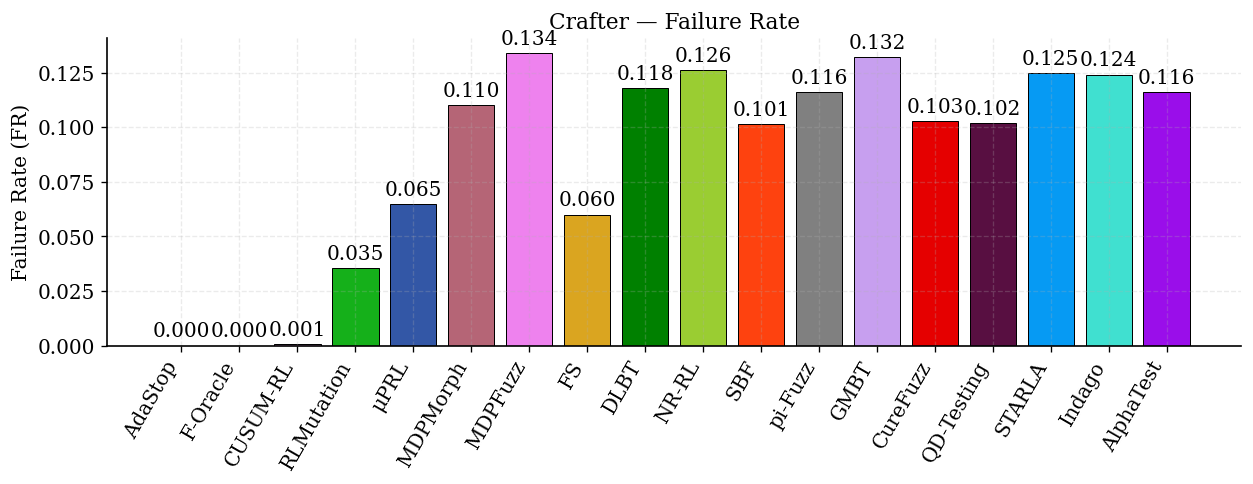

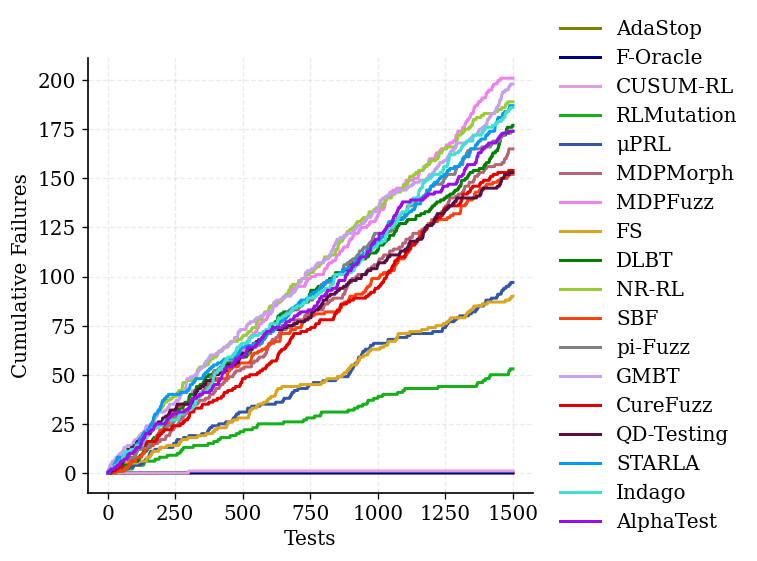

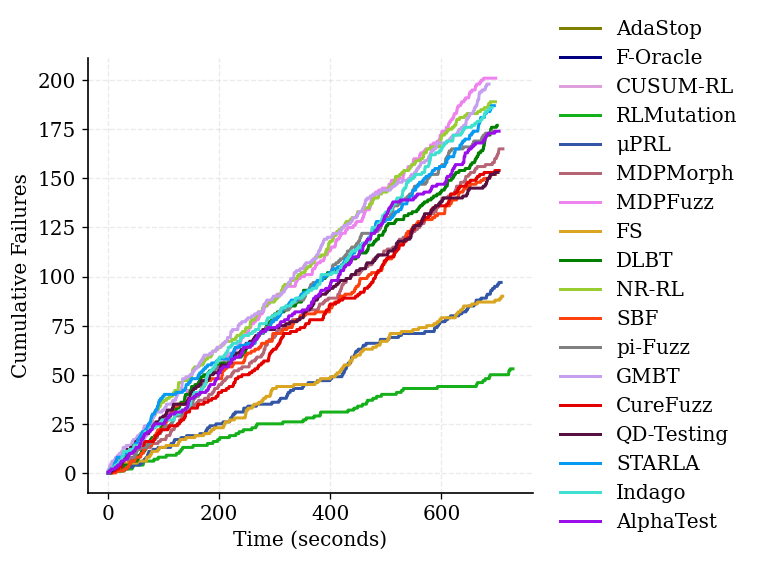

In [43]:
# ============================================================
# Plot Results
# ============================================================

CSV_PATH = TABLES_DIR / "single_row_metrics.csv"
df = pd.read_csv(CSV_PATH)

def _col(fw):
    return COL.get(fw, "#777777")

plt.rcParams.update({
    "figure.figsize": (10.5, 4.2),
    "font.family": "serif",
    "font.size": 12,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

# ------------------------------------------------------------
# 1) Failure Rate Bar Plot
# ------------------------------------------------------------

plt.figure()
colors = [_col(fw) for fw in df["framework"]]

bars = plt.bar(
    df["framework"],
    df["FR"].fillna(0.0),
    color=colors,
    edgecolor="black",
    linewidth=0.6,
)
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=60, ha="right")
plt.ylabel("Failure Rate (FR)")
plt.title("Crafter — Failure Rate")
plt.tight_layout()
plt.savefig(FIGS_DIR / "crafter_FR_bar.png", dpi=300)
plt.show()

# ------------------------------------------------------------
# 2) Cumulative Failures vs Tests
# ------------------------------------------------------------

plt.figure(figsize=(6.5, 4.8))

for fw in df["framework"]:
    path = RAW_DIR / f"{fw}_episodes.csv"
    if not path.exists():
        continue

    d = pd.read_csv(path)
    if "failure" not in d.columns:
        continue

    y = np.cumsum(d["failure"].astype(int).values)
    x = np.arange(1, len(y) + 1)

    plt.plot(x, y, label=fw, color=_col(fw), linewidth=1.8)

plt.xlabel("Tests")
plt.ylabel("Cumulative Failures")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig(FIGS_DIR / "crafter_CF_vs_tests.png", dpi=300)
plt.show()

# ------------------------------------------------------------
# 3) Cumulative Failures vs Time
# ------------------------------------------------------------

plt.figure(figsize=(6.5, 4.8))

for fw in df["framework"]:
    path = RAW_DIR / f"{fw}_episodes.csv"
    if not path.exists():
        continue

    d = pd.read_csv(path)
    if not {"failure", "wall_dt"}.issubset(d.columns):
        continue

    y = np.cumsum(d["failure"].astype(int).values)
    x = np.cumsum(d["wall_dt"].astype(float).values)

    plt.plot(x, y, label=fw, color=_col(fw), linewidth=1.8)

plt.xlabel("Time (seconds)")
plt.ylabel("Cumulative Failures")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig(FIGS_DIR / "crafter_CF_vs_time.png", dpi=300)
plt.show()